In [1]:
import numpy as np
import pandas as pd
import warnings
import re
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
import string
from string import punctuation
from nltk.corpus import stopwords
from statistics import mean
from heapq import nlargest
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
df_1 = pd.read_csv("/kaggle/input/all-the-news/articles1.csv")
df_2 = pd.read_csv("/kaggle/input/all-the-news/articles2.csv")
df_3 = pd.read_csv("/kaggle/input/all-the-news/articles3.csv")

In [3]:
# Checking if the columns are same or not
df_1.columns == df_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [4]:
# Checking if the columns are same or not
df_2.columns == df_3.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [5]:
# Making one Dataframe by appending all of them for the further process
d = [df_1, df_2, df_3]
df = pd.concat(d, keys = ['x', 'y', 'z'])
df.rename(columns = {'content' : 'article'}, inplace = True);

In [6]:
df.head()

Unnamed: 0     id                                              title  \
x 0           0  17283  House Republicans Fret About Winning Their Hea...   
  1           1  17284  Rift Between Officers and Residents as Killing...   
  2           2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
  3           3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
  4           4  17287  Kim Jong-un Says North Korea Is Preparing to T...   

        publication                         author        date    year  month  \
x 0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
  1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
  2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
  3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
  4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

     url                                            article  
x 0  NaN  WASHINGTON  —   Congressional Republicans have...  
  1  NaN  After the bullet shells get counted, the blood...  
  2  NaN  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  NaN  Death may be the great equalizer, but it isn’t...  
  4  NaN  SEOUL, South Korea  —   North Korea’s leader, ...

In [7]:
# Shape of the dataset
print ("The shape of the dataset : ", df.shape)

The shape of the dataset :  (142570, 10)


In [8]:
# Dropping the unnecessary columns
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

id                                              title     publication  \
x 0  17283  House Republicans Fret About Winning Their Hea...  New York Times   
  1  17284  Rift Between Officers and Residents as Killing...  New York Times   
  2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...  New York Times   
  3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...  New York Times   
  4  17287  Kim Jong-un Says North Korea Is Preparing to T...  New York Times   

                            author        date    year  month  url  \
x 0                     Carl Hulse  2016-12-31  2016.0   12.0  NaN   
  1  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0  NaN   
  2                   Margalit Fox  2017-01-06  2017.0    1.0  NaN   
  3               William McDonald  2017-04-10  2017.0    4.0  NaN   
  4                  Choe Sang-Hun  2017-01-02  2017.0    1.0  NaN   

                                               article  
x 0  WASHINGTON  —   Congressional Republicans have...  
  1  After the bullet shells get counted, the blood...  
  2  When Walt Disney’s “Bambi” opened in 1942, cri...  
  3  Death may be the great equalizer, but it isn’t...  
  4  SEOUL, South Korea  —   North Korea’s leader, ...

[Text(0.5, 0, 'Publication'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of Publication according')]

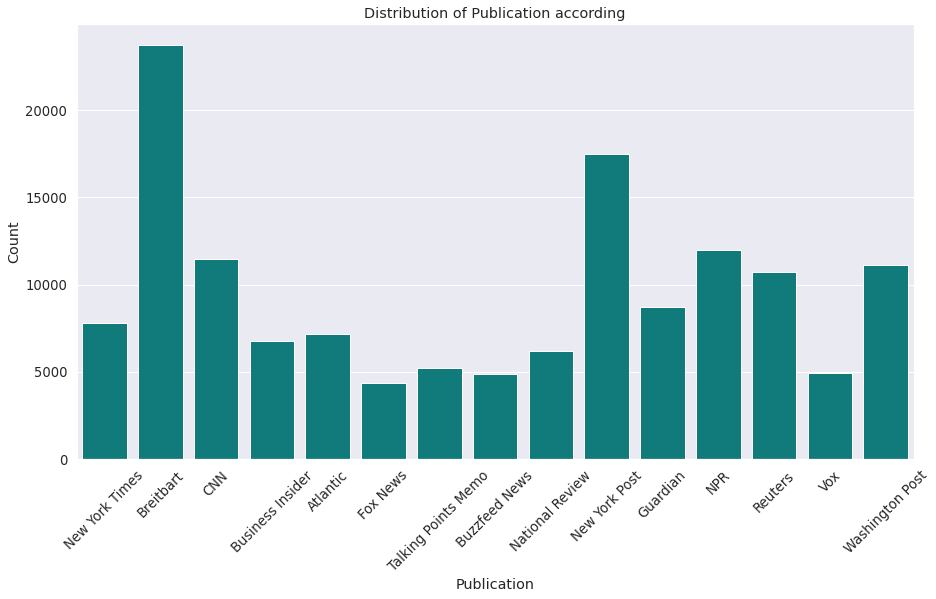

In [9]:
# Countplot shows the distribution of Publication
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_year = sns.countplot(df['publication'], color = 'darkcyan')
plt.xticks(rotation=45)
sns_year.set(xlabel = "Publication", ylabel = "Count", title = "Distribution of Publication according")

# 2 Exploratory Data Analysis

# 3 Making the Article Summarizer

In [10]:
contractions_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesn’t": "does not",
"don't": "do not",
"don’t": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y’all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he had",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’re": "you are",
"you’ve": "you have",
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
# Function to clean the html from the article
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    # Removing the HTML
    article = article.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    article = article.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    article = article.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Removing the '\xa0'
    article = article.apply(lambda x: x.replace("\xa0", " "))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    article = article.apply(lambda x: x.replace("'s", ''))
    article = article.apply(lambda x: x.replace('’s', ''))
    article = article.apply(lambda x: x.replace("\'s", ''))
    article = article.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

# Function to normalize the word frequency which is used in the function word_frequency
def normalize(li_word):
    global normalized_freq
    normalized_freq = []
    for dictionary in li_word:
        max_frequency = max(dictionary.values())
        for word in dictionary.keys():
            dictionary[word] = dictionary[word]/max_frequency
        normalized_freq.append(dictionary)
    return normalized_freq

# Function to calculate the word frequency
def word_frequency(article_word):
    word_frequency = {}
    li_word = []
    for sentence in article_word:
        for word in word_tokenize(sentence):
            if word not in word_frequency.keys():
                word_frequency[word] = 1
            else:
                word_frequency[word] += 1
        li_word.append(word_frequency)
        word_frequency = {}
    normalize(li_word)
    return normalized_freq

# Function to Score the sentence which is called in the function sent_token
def sentence_score(li):
    global sentence_score_list
    sentence_score = {}
    sentence_score_list = []
    for list_, dictionary in zip(li, normalized_freq):
        for sent in list_:
            for word in word_tokenize(sent):
                if word in dictionary.keys():
                    if sent not in sentence_score.keys():
                        sentence_score[sent] = dictionary[word]
                    else:
                        sentence_score[sent] += dictionary[word]
        sentence_score_list.append(sentence_score)
        sentence_score = {}
    return sentence_score_list

# Function to tokenize the sentence
def sent_token(article_sent):
    sentence_list = []
    sent_token = []
    for sent in article_sent:
        token = sent_tokenize(sent)
        for sentence in token:
            token_2 = ''.join(word for word in sentence if word not in punctuation)
            token_2 = re.sub(' +', ' ',token_2)
            sent_token.append(token_2)
        sentence_list.append(sent_token)
        sent_token = []
    sentence_score(sentence_list)
    return sentence_score_list

# Function which generates the summary of the articles (This uses the 20% of the sentences with the highest score)
def summary(sentence_score_OwO):
    summary_list = []
    for summ in sentence_score_OwO:
        select_length = int(len(summ)*0.25)
        summary_ = nlargest(select_length, summ, key = summ.get)
        summary_list.append(".".join(summary_))
    return summary_list


# Functions to change the article string (if passed) to change it to generate a pandas series
def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

# Function which is to be called to generate the summary which in further calls other functions alltogether
def article_summarize(artefact):
    
    if type(artefact) != pd.Series:
        artefact = make_series(artefact)
    
    df = preprocessing(artefact)
    
    word_normalization = word_frequency(df)
    
    sentence_score_OwO = sent_token(article_sent)
    
    summarized_article = summary(sentence_score_OwO)
    
    return summarized_article

In [15]:
text="""Renewable energy is a multifaceted and critical topic in the context of todays global challenges. With an increasing awareness of the environmental impact of traditional fossil fuels and the looming threat of climate change, renewable energy sources have become the focal point of discussions, innovations, and policies. This extensive 2000-word paragraph will delve into the various aspects of renewable energy, exploring its significance, the different types of renewable resources, their applications, advantageenergy future.Significance of Renewablegy or green energy, encompasses a range of energy sources that are naturally replenished, such as sunlight, wind, rain, tides, waves, and geothermal heat. The significance of renewable energy lies in its potential to address several pressing global issues.First and foremost, renewable energy is a powerful tool in mitigating climate change. The burning of fossil fuels for energy production is a major contributor to the emission of greenhouse gases, primarily carbon dioxide (CO2), which traps heat in the Earths atmosphere and leads to global warming. The consequences of climate change, including rising sea levels, more frequent and severe weather events, and disruptions to ecosystems, pose a direct threat to human societies and the planet. Transitioning to renewable energy sources can significantly reduce these emissions, providing a path toward a more sustainable and less climate-vulnerable future.Moreover, renewable energy contributes to energy security by diversifying energy sources and reducing dependence on finite and geopolitically unstable fossil fuels. This enhances a nations resilience to energy supply disruptions and price fluctuations, thereby promoting economic stability.Renewable energy also presents economic opportunities. The renewable energy sector has seen substantial growth in recent years, creating jobs and stimulating economic development. As the technology advances and the industry matures, it has the potential to become a major driver of economic growth, particularly in regions with abundant renewable resources.Types of Renewable Energy Sources:Solar Energy: Solar energy is harnessed through photovoltaic cells, which convert sunlight directly into electricity, and solar thermal systems, which use sunlight to heat a fluid that generates steam to drive a turbine.Wind Energy: Wind turbines capture the kinetic energy of moving air and convert it into electrical power. Wind energy is one of the fastest-growing renewable energy sources.Hydropower: Hydropower, or hydroelectric power, utilizes the energy of flowing or falling water to generate electricity. It can be harnessed through dams, run-of-river systems, or tidal and wave energy.Geothermal Energy: Geothermal energy exploits the heat from within the Earths core to generate electricity or provide heating and cooling for buildings.Biomass Energy: Biomass energy is produced from organic materials, including wood, agricultural residues, and even municipal solid waste. It can be used to generate heat, electricity, or biofuels.Each of these renewable energy sources has unique advantages and applications, making them suitable for different regions and purposes.Applications of Renewable Energy:Electricity Generation: The most common application of renewable energy is in electricity generation. Solar panels, wind turbines, and hydropower plants are used to produce electricity that can power homes, businesses, and industries.Heating and Cooling: Geothermal heat pumps and solar thermal systems are used to provide heating and cooling for buildings. They are particularly energy-efficient and can reduce the carbon footprint of heating and cooling processes.Transportation: Renewable energy sources play a crucial role in reducing the carbon emissions associated with transportation. Electric vehicles (EVs) are powered by electricity, which can be generated from renewable sources, thus decreasing the reliance on gasoline and diesel.Industrial Processes: Some industries use renewable energy to power their processes and reduce their carbon emissions. For example, biomass can be used in the production of biofuels or as a source of heat in industrial processes.Advantages of Renewable Energy:The advantages of renewable energy are numerous and contribute to its growing importance in the world:Environmentally Friendly: Renewable energy sources are clean and produce little to no air or water pollution. They do not emit greenhouse gases, making them a crucial tool in combatting climate change.Abundant and Sustainable: Unlike fossil fuels, which are finite resources, renewable energy sources are essentially inexhaustible. The sun will continue to shine, the wind will keep blowing, and water will flow as long as the Earth exists.Energy Independence: By harnessing renewable resources locally, regions and countries can reduce their reliance on energy imports and enhance their energy security.Job Creation: The renewable energy sector has been a significant source of job creation, with opportunities ranging from manufacturing and installation to research and development.Reduced Operating Costs: Over time, renewable energy systems can lead to cost savings, as they often have lower operating and maintenance expenses compared to fossil fuel-based power plants.Technological Innovation: The pursuit of renewable energy has driven innovation in technology and materials, leading to advancements in efficiency and cost-effectiveness.Challenges and Considerations:While the benefits of renewable energy are compelling, there are also challenges and considerations that must be addressed:Intermittency: Some renewable sources, such as wind and solar, are intermittent, meaning they are not always available. This intermittency requires the development of energy storage solutions and a resilient grid infrastructure to ensure a reliable power supply.Energy Storage: Effective energy storage is essential to store excess energy generated during periods of high renewable resource availability and release it when demand is high or resources are scarce.Infrastructure and Investment: Transitioning to renewable energy requires substantial infrastructure investments, including the construction of wind and solar farms, grid enhancements, and research and development in energy technologies.Policy and Regulation: Supportive policies and regulations, such as incentives, tax credits, and renewable portfolio standards, are critical to drive the adoption of renewable energy.Resource Availability: The feasibility of renewable energy adoption varies by location, as it depends on the availability of specific renewable resources. Not all regions have abundant wind, sunlight, or geothermal heat.Environmental Impact: While renewable energy is generally considered environmentally friendly, some technologies, such as large hydropower dams, can have significant ecological impacts. Its important to carefully assess and mitigate these impacts.The Transition to a Sustainable Energy Future:The transition to renewable energy is a complex and ongoing process. It involves the integration of clean energy sources into existing energy systems, the development of new technologies, and the reevaluation of energy policies and practices. Governments, industries, and individuals all play crucial roles in this transition.At the governmental level, there is a growing consensus on the importance of renewable energy in addressing climate change. Many countries have set ambitious renewable energy targets and are implementing policies to encourage the adoption of clean energy sources. International agreements like the Paris Agreement have further emphasized the global commitment to reducing carbon emissions and promoting renewable energy.The energy industry itself has undergone significant changes as it embraces renewable technologies. Utilities are investing in wind and solar projects, and fossil fuel companies are diversifying into cleaner energy sources. Additionally, the emergence of distributed energy systems, such as rooftop solar panels and microgrids, is changing the way energy is produced and consumed.Individuals have also become more engaged in the renewable energy transition."""
#text="Renewable energy is a multifaceted and critical topic in the context of today's global challenges. With an increasing awareness of the environmental impact of traditional fossil fuels and the looming threat of climate change, renewable energy sources have become the focal point of discussions, innovations, and policies. This extensive 2000-word paragraph will delve into the various aspects of renewable energy, exploring its significance, the different types of renewable resources, their applications, advantages, challenges, and the role they play in the ongoing transition to a more sustainable energy future.Significance of Renewable Energy:Renewable energy, often referred to as "clean energy" or "green energy," encompasses a range of energy sources that are naturally replenished, such as sunlight, wind, rain, tides, waves, and geothermal heat. The significance of renewable energy lies in its potential to address several pressing global issues.First and foremost, renewable energy is a powerful tool in mitigating climate change. The burning of fossil fuels for energy production is a major contributor to the emission of greenhouse gases, primarily carbon dioxide (CO2), which traps heat in the Earth's atmosphere and leads to global warming."
#text="Renewable energy is a multifaceted and critical topic in the context of today's global challenges. With an increasing awareness of the environmental impact of traditional fossil fuels and the looming threat of climate change, renewable energy sources have become the focal point of discussions, innovations, and policies. This extensive 2000-word paragraph will delve into the various aspects of renewable energy, exploring its significance, the different types of renewable resources, their applications, advantages, challenges, and the role they play in the ongoing transition to a more sustainable energy future.Significance of Renewable Energy:Renewable energy, often referred to as "clean energy" or "green energy," encompasses a range of energy sources that are naturally replenished, such as sunlight, wind, rain, tides, waves, and geothermal heat. The significance of renewable energy lies in its potential to address several pressing global issues.First and foremost, renewable energy is a powerful tool in mitigating climate change. The burning of fossil fuels for energy production is a major contributor to the emission of greenhouse gases, primarily carbon dioxide (CO2), which traps heat in the Earth's atmosphere and leads to global warming. The consequences of climate change, including rising sea levels, more frequent and severe weather events, and disruptions to ecosystems, pose a direct threat to human societies and the planet. Transitioning to renewable energy sources can significantly reduce these emissions, providing a path toward a more sustainable and less climate-vulnerable future.Moreover, renewable energy contributes to energy security by diversifying energy sources and reducing dependence on finite and geopolitically unstable fossil fuels. This enhances a nation's resilience to energy supply disruptions and price fluctuations, thereby promoting economic stability.Renewable energy also presents economic opportunities. The renewable energy sector has seen substantial growth in recent years, creating jobs and stimulating economic development. As the technology advances and the industry matures, it has the potential to become a major driver of economic growth, particularly in regions with abundant renewable resources.Types of Renewable Energy Sources:Solar Energy: Solar energy is harnessed through photovoltaic cells, which convert sunlight directly into electricity, and solar thermal systems, which use sunlight to heat a fluid that generates steam to drive a turbine.Wind Energy: Wind turbines capture the kinetic energy of moving air and convert it into electrical power. Wind energy is one of the fastest-growing renewable energy sources.Hydropower: Hydropower, or hydroelectric power, utilizes the energy of flowing or falling water to generate electricity. It can be harnessed through dams, run-of-river systems, or tidal and wave energy.Geothermal Energy: Geothermal energy exploits the heat from within the Earth's core to generate electricity or provide heating and cooling for buildings.Biomass Energy: Biomass energy is produced from organic materials, including wood, agricultural residues, and even municipal solid waste. It can be used to generate heat, electricity, or biofuels.Each of these renewable energy sources has unique advantages and applications, making them suitable for different regions and purposes.Applications of Renewable Energy:Electricity Generation: The most common application of renewable energy is in electricity generation. Solar panels, wind turbines, and hydropower plants are used to produce electricity that can power homes, businesses, and industries.Heating and Cooling: Geothermal heat pumps and solar thermal systems are used to provide heating and cooling for buildings. They are particularly energy-efficient and can reduce the carbon footprint of heating and cooling processes.Transportation: Renewable energy sources play a crucial role in reducing the carbon emissions associated with transportation. Electric vehicles (EVs) are powered by electricity, which can be generated from renewable sources, thus decreasing the reliance on gasoline and diesel.Industrial Processes: Some industries use renewable energy to power their processes and reduce their carbon emissions. For example, biomass can be used in the production of biofuels or as a source of heat in industrial processes.Advantages of Renewable Energy:The advantages of renewable energy are numerous and contribute to its growing importance in the world:Environmentally Friendly: Renewable energy sources are clean and produce little to no air or water pollution. They do not emit greenhouse gases, making them a crucial tool in combatting climate change.Abundant and Sustainable: Unlike fossil fuels, which are finite resources, renewable energy sources are essentially inexhaustible. The sun will continue to shine, the wind will keep blowing, and water will flow as long as the Earth exists.Energy Independence: By harnessing renewable resources locally, regions and countries can reduce their reliance on energy imports and enhance their energy security.Job Creation: The renewable energy sector has been a significant source of job creation, with opportunities ranging from manufacturing and installation to research and development.Reduced Operating Costs: Over time, renewable energy systems can lead to cost savings, as they often have lower operating and maintenance expenses compared to fossil fuel-based power plants.Technological Innovation: The pursuit of renewable energy has driven innovation in technology and materials, leading to advancements in efficiency and cost-effectiveness.Challenges and Considerations:While the benefits of renewable energy are compelling, there are also challenges and considerations that must be addressed:Intermittency: Some renewable sources, such as wind and solar, are intermittent, meaning they are not always available. This intermittency requires the development of energy storage solutions and a resilient grid infrastructure to ensure a reliable power supply.Energy Storage: Effective energy storage is essential to store excess energy generated during periods of high renewable resource availability and release it when demand is high or resources are scarce.Infrastructure and Investment: Transitioning to renewable energy requires substantial infrastructure investments, including the construction of wind and solar farms, grid enhancements, and research and development in energy technologies.Policy and Regulation: Supportive policies and regulations, such as incentives, tax credits, and renewable portfolio standards, are critical to drive the adoption of renewable energy.Resource Availability: The feasibility of renewable energy adoption varies by location, as it depends on the availability of specific renewable resources. Not all regions have abundant wind, sunlight, or geothermal heat.Environmental Impact: While renewable energy is generally considered environmentally friendly, some technologies, such as large hydropower dams, can have significant ecological impacts. It's important to carefully assess and mitigate these impacts.The Transition to a Sustainable Energy Future:The transition to renewable energy is a complex and ongoing process. It involves the integration of clean energy sources into existing energy systems, the development of new technologies, and the reevaluation of energy policies and practices. Governments, industries, and individuals all play crucial roles in this transition.At the governmental level, there is a growing consensus on the importance of renewable energy in addressing climate change. Many countries have set ambitious renewable energy targets and are implementing policies to encourage the adoption of clean energy sources. International agreements like the Paris Agreement have further emphasized the global commitment to reducing carbon emissions and promoting renewable energy.The energy industry itself has undergone significant changes as it embraces renewable technologies. Utilities are investing in wind and solar projects, and fossil fuel companies are diversifying into cleaner energy so"
#text="Renewable energy is a multifaceted and critical topic in the context of today's global challenges. With an increasing awareness of the environmental impact of traditional fossil fuels and the looming threat of climate change, renewable energy sources have become the focal point of discussions, innovations, and policies. This extensive 2000-word paragraph will delve into the various aspects of renewable energy, exploring its significance, the different types of renewable resources, their applications, advantages, challenges, and the role they play in the ongoing transition to a more sustainable energy future.Significance of Renewable Energy:Renewable energy, often referred to as "clean energy" or "green energy," encompasses a range of energy sources that are naturally replenished, such as sunlight, wind, rain, tides, waves, and geothermal heat. The significance of renewable energy lies in its potential to address several pressing global issues.First and foremost, renewable energy is a powerful tool in mitigating climate change. The burning of fossil fuels for energy production is a major contributor to the emission of greenhouse gases, primarily carbon dioxide (CO2), which traps heat in the Earth's atmosphere and leads to global warming. The consequences of climate change, including rising sea levels, more frequent and severe weather events, and disruptions to ecosystems, pose a direct threat to human societies and the planet. Transitioning to renewable energy sources can significantly reduce these emissions, providing a path toward a more sustainable and less climate-vulnerable future.Moreover, renewable energy contributes to energy security by diversifying energy sources and reducing dependence on finite and geopolitically unstable fossil fuels. This enhances a nation's resilience to energy supply disruptions and price fluctuations, thereby promoting economic stability.Renewable energy also presents economic opportunities. The renewable energy sector has seen substantial growth in recent years, creating jobs and stimulating economic development. As the technology advances and the industry matures, it has the potential to become a major driver of economic growth, particularly in regions with abundant renewable resources.Types of Renewable Energy Sources:Solar Energy: Solar energy is harnessed through photovoltaic cells, which convert sunlight directly into electricity, and solar thermal systems, which use sunlight to heat a fluid that generates steam to drive a turbine.Wind Energy: Wind turbines capture the kinetic energy of moving air and convert it into electrical power. Wind energy is one of the fastest-growing renewable energy sources.Hydropower: Hydropower, or hydroelectric power, utilizes the energy of flowing or falling water to generate electricity. It can be harnessed through dams, run-of-river systems, or tidal and wave energy.Geothermal Energy: Geothermal energy exploits the heat from within the Earth's core to generate electricity or provide heating and cooling for buildings.Biomass Energy: Biomass energy is produced from organic materials, including wood, agricultural residues, and even municipal solid waste. It can be used to generate heat, electricity, or biofuels.Each of these renewable energy sources has unique advantages and applications, making them suitable for different regions and purposes.Applications of Renewable Energy:Electricity Generation: The most common application of renewable energy is in electricity generation. Solar panels, wind turbines, and hydropower plants are used to produce electricity that can power homes, businesses, and industries.Heating and Cooling: Geothermal heat pumps and solar thermal systems are used to provide heating and cooling for buildings. They are particularly energy-efficient and can reduce the carbon footprint of heating and cooling processes.Transportation: Renewable energy sources play a crucial role in reducing the carbon emissions associated with transportation. Electric vehicles (EVs) are powered by electricity, which can be generated from renewable sources, thus decreasing the reliance on gasoline and diesel.Industrial Processes: Some industries use renewable energy to power their processes and reduce their carbon emissions. For example, biomass can be used in the production of biofuels or as a source of heat in industrial processes.Advantages of Renewable Energy:The advantages of renewable energy are numerous and contribute to its growing importance in the world:Environmentally Friendly: Renewable energy sources are clean and produce little to no air or water pollution. They do not emit greenhouse gases, making them a crucial tool in combatting climate change.Abundant and Sustainable: Unlike fossil fuels, which are finite resources, renewable energy sources are essentially inexhaustible. The sun will continue to shine, the wind will keep blowing, and water will flow as long as the Earth exists.Energy Independence: By harnessing renewable resources locally, regions and countries can reduce their reliance on energy imports and enhance their energy security.Job Creation: The renewable energy sector has been a significant source of job creation, with opportunities ranging from manufacturing and installation to research and development.Reduced Operating Costs: Over time, renewable energy systems can lead to cost savings, as they often have lower operating and maintenance expenses compared to fossil fuel-based power plants.Technological Innovation: The pursuit of renewable energy has driven innovation in technology and materials, leading to advancements in efficiency and cost-effectiveness.Challenges and Considerations:While the benefits of renewable energy are compelling, there are also challenges and considerations that must be addressed:Intermittency: Some renewable sources, such as wind and solar, are intermittent, meaning they are not always available. This intermittency requires the development of energy storage solutions and a resilient grid infrastructure to ensure a reliable power supply.Energy Storage: Effective energy storage is essential to store excess energy generated during periods of high renewable resource availability and release it when demand is high or resources are scarce.Infrastructure and Investment: Transitioning to renewable energy requires substantial infrastructure investments, including the construction of wind and solar farms, grid enhancements, and research and development in energy technologies.Policy and Regulation: Supportive policies and regulations, such as incentives, tax credits, and renewable portfolio standards, are critical to drive the adoption of renewable energy.Resource Availability: The feasibility of renewable energy adoption varies by location, as it depends on the availability of specific renewable resources. Not all regions have abundant wind, sunlight, or geothermal heat.Environmental Impact: While renewable energy is generally considered environmentally friendly, some technologies, such as large hydropower dams, can have significant ecological impacts. It's important to carefully assess and mitigate these impacts.The Transition to a Sustainable Energy Future:The transition to renewable energy is a complex and ongoing process. It involves the integration of clean energy sources into existing energy systems, the development of new technologies, and the reevaluation of energy policies and practices. Governments, industries, and individuals all play crucial roles in this transition.At the governmental level, there is a growing consensus on the importance of renewable energy in addressing climate change. Many countries have set ambitious renewable energy targets and are implementing policies to encourage the adoption of clean energy sources. International agreements like the Paris Agreement have further emphasized the global commitment to reducing carbon emissions and promoting renewable energy.The energy industry itself has undergone significant changes as it embraces renewable technologies. Utilities are investing in wind and solar projects, and fossil fuel companies are diversifying into cleaner energy sources. Additionally, the emergence of distributed energy systems, such as rooftop solar panels and microgrids, is changing the way energy is produced and consumed.Individuals have also become more engaged in the renewable energy transition."

In [16]:
# Generating the Word Cloud of the article using the preprocessing and make_series function mentioned below
def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
#     plt.figure(figsize=(15, 10))
#     plt.imshow(wordcloud_, interpolatio"n='bilinear')
#     plt.axis('off');
# Generating the summaries for the first 100 articles
summaries = article_summarize(text)

In [17]:
print ("The Actual length of the article is : ", len(text))

The Actual length of the article is :  8256


In [18]:
print ("The length of the summarized article is : ", len(summaries[0]))
summaries[0]

The length of the summarized article is :  3859


'the sun will continue to shine the wind will keep blowing and water will flow as long as the earth existsenergy independence by harnessing renewable resources locally regions and countries can reduce their reliance on energy imports and enhance their energy securityjob creation the renewable energy sector has been a significant source of job creation with opportunities ranging from manufacturing and installation to research and developmentreduced operating costs over time renewable energy systems can lead to cost savings as they often have lower operating and maintenance expenses compared to fossil fuelbased power plantstechnological innovation the pursuit of renewable energy has driven innovation in technology and materials leading to advancements in efficiency and costeffectivenesschallenges and considerationswhile the benefits of renewable energy are compelling there are also challenges and considerations that must be addressedintermittency some renewable sources such as wind and s